# Graph

## 1. Graphe des Produits

**Objectif :** Trouver les produits fréquemment commandés ensemble

### 1.1 Construction du Graphe

In [36]:
# LOAD DATASET & PREPROCESSING

import pandas as pd

# Load datasets ###############################################################
df_products = pd.read_csv('../datasets/olist_products_dataset.csv')
df_order_items = pd.read_csv('../datasets/olist_order_items_dataset.csv')

# Preprocessing ################################################################
# Drop rows with missing values
df_products.dropna(inplace=True)
df_order_items.dropna(inplace=True)

# Drop columns that are not useful for the analysis 
df_products.drop(columns=['product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm'], inplace=True)
df_order_items.drop(columns=['shipping_limit_date', 'freight_value', 'seller_id', 'price'], inplace=True)

# Drop duplicates
df_products.drop_duplicates(inplace=True)
df_order_items.drop_duplicates(inplace=True)

# Display df columns and number of rows
print("\n___ Products ___")
print("[ " + " | ".join(df_products.columns) + " ]")
print(f"Number of rows: {df_products.shape[0]}")

print("\n___ Order Items ___")
print("[ " + " | ".join(df_order_items.columns) + " ]")
print(f"Number of rows: {df_order_items.shape[0]}")



___ Products ___
[ product_id | product_category_name ]
Number of rows: 32340

___ Order Items ___
[ order_id | order_item_id | product_id ]
Number of rows: 112650


In [37]:
# CREATE GRAPH 
import networkx as nx
# Constants
min_orders = 40
# Create a graph ################################################################
G_products = nx.Graph()

# Add nodes (products)
products = df_order_items['product_id'].value_counts()
filtered_products = products[products >= min_orders]
G_products.add_nodes_from(filtered_products.index)
# Add count attribute
nx.set_node_attributes(G_products, dict(filtered_products), 'count')

# Add product category attribute, if no category create one NONE
product_categories = df_products.set_index('product_id')['product_category_name'].to_dict()
for product in filtered_products.index:
    if product not in product_categories:
        product_categories[product] = 'NONE'
nx.set_node_attributes(G_products, product_categories, 'category')

# Add edges (products bought together)
order_products = df_order_items.groupby('order_id')['product_id'].apply(list)
for products in order_products:
    for i in range(len(products)):
        for j in range(i+1, len(products)):
            if products[i] in filtered_products.index and products[j] in filtered_products.index:
                if G_products.has_edge(products[i], products[j]):
                    G_products[products[i]][products[j]]['weight'] += 1
                else:
                    G_products.add_edge(products[i], products[j], weight=1)

# Clean graph #################################################################
# Remove self loops
G_products.remove_edges_from(nx.selfloop_edges(G_products))
# Remove nodes with no edges
G_products.remove_nodes_from(list(nx.isolates(G_products)))

# Display graph info
print("\n___ Graph ___")
print(f"Number of nodes: {G_products.number_of_nodes()}")
first_node = list(G_products.nodes)[0]
print(f"Nodes attributes names: {G_products.nodes[first_node].keys()}")
print(f"Number of edges: {G_products.number_of_edges()}")
print(f"Edges attributes names: {G_products.edges[first_node, list(G_products.neighbors(first_node))[0]].keys()}")

print(f"Average degree: {sum(dict(G_products.degree()).values())/G_products.number_of_nodes()}")
print(f"Density: {nx.density(G_products)}")


___ Graph ___
Number of nodes: 71
Nodes attributes names: dict_keys(['count', 'category'])
Number of edges: 66
Edges attributes names: dict_keys(['weight'])
Average degree: 1.8591549295774648
Density: 0.026559356136820925


### 1.2 Détection des Communautés

Identifier des groupes de produits souvent commandés ensemble pour révéler des catégories naturelles.


___ Community detection ___
Number of communities: 23
Communities sizes: 9, 7, 6, 4, 4, 4, 3, 3, 3, 2, ...


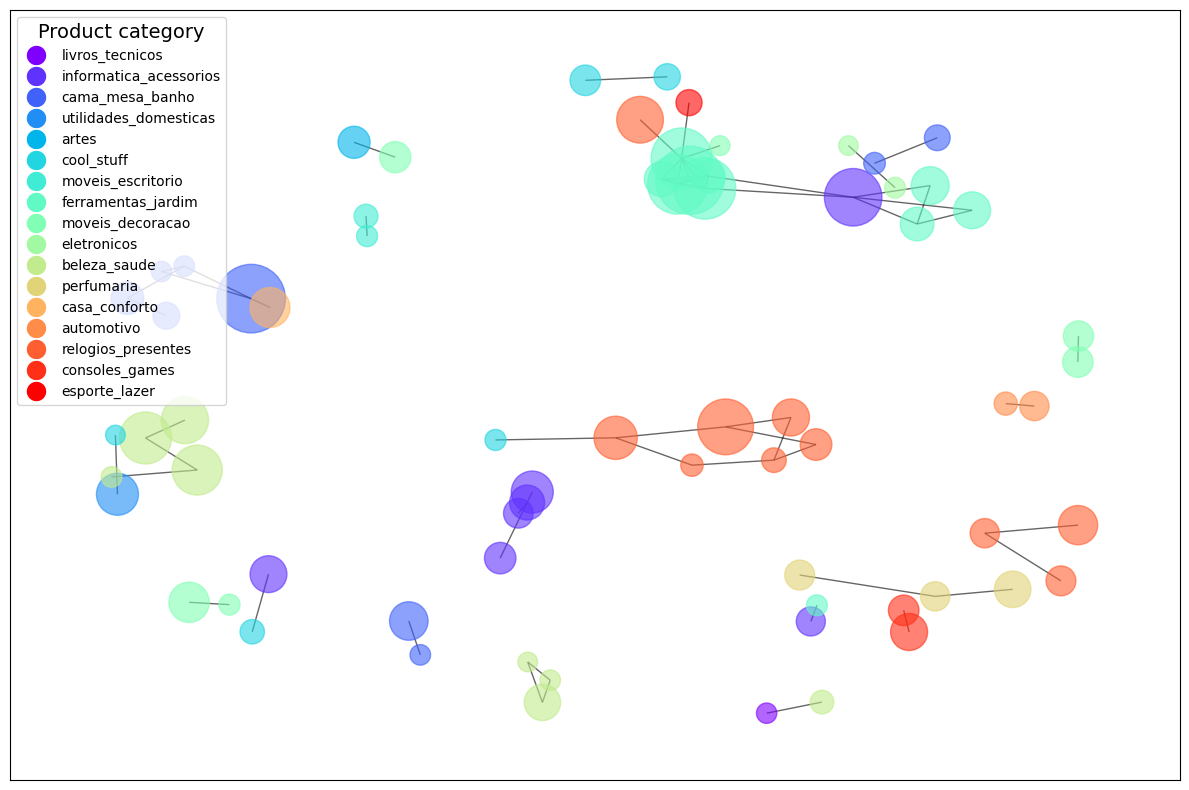

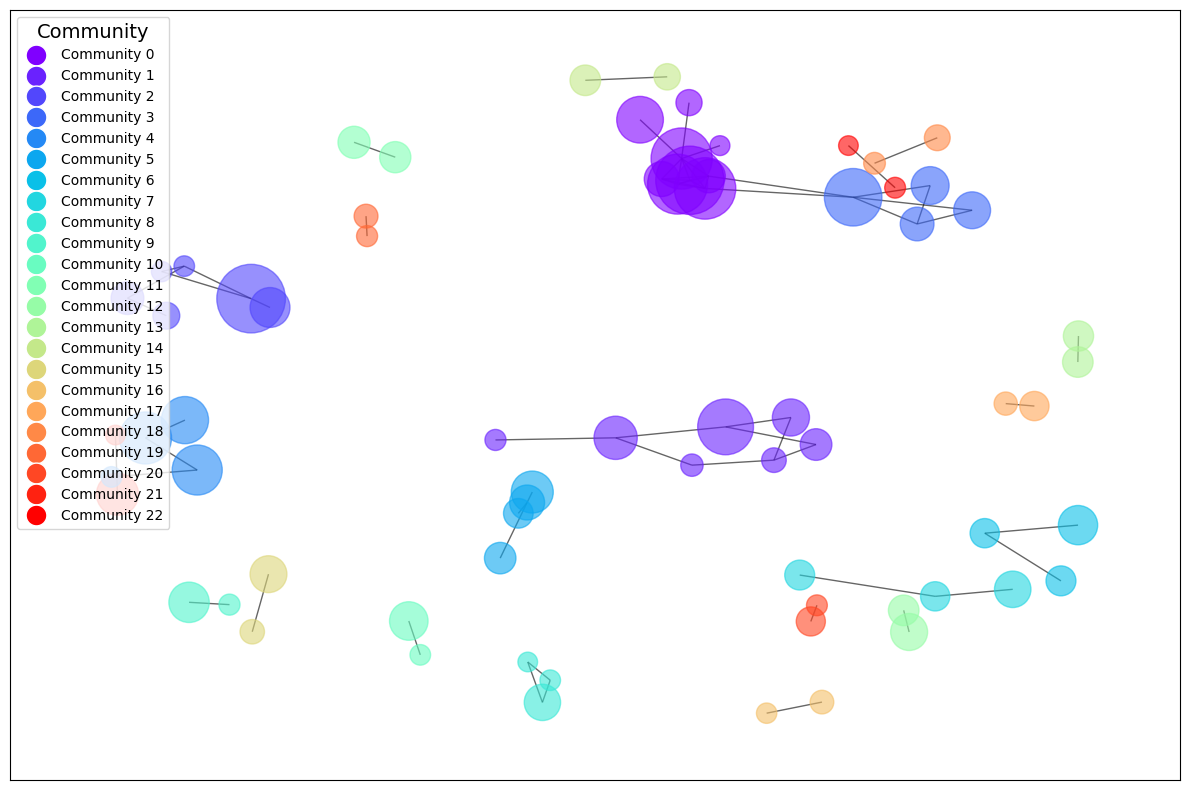

In [38]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Comunity detection (Louvain algorithm) #######################################
community = nx.community.louvain_communities(G_products, weight='weight')
community = sorted(community, key=len, reverse=True)
print("\n___ Community detection ___")
print(f"Number of communities: {len(community)}")
print(f"Communities sizes: {', '.join([str(len(c)) for c in community][:10])}, ...")

# Map each node to its community
node_community_map = {}
for i, comm in enumerate(community):
    for node in comm:
        node_community_map[node] = i

# Plot graphs ###################################################################
# Plot categories distribution
categories = list(set(nx.get_node_attributes(G_products, 'category').values()))
colors = plt.cm.rainbow(np.linspace(0, 1, len(categories)))
category_colors = dict(zip(categories, colors))
# Draw the graph
plt.figure(figsize=(12, 8))
position = nx.spring_layout(G_products, k=0.3, iterations=50)
node_sizes = [G_products.nodes[n]['count'] * 5 for n in G_products.nodes]
node_colors = [category_colors[G_products.nodes[n]['category']] for n in G_products.nodes]
nx.draw_networkx(G_products, position, node_color=node_colors, node_size=node_sizes, alpha=0.6, with_labels=False)
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=category, markerfacecolor=color, markersize=15)
                   for category, color in category_colors.items()]
plt.legend(handles=legend_elements, title="Product category", loc='upper left', title_fontsize=14)
plt.tight_layout()
plt.savefig('./images/graph-products-categories.png')
plt.show()

# Plot communities distribution
community_colors = plt.cm.rainbow(np.linspace(0, 1, len(community)))
community_colors = dict(zip(range(len(community)), community_colors))
# Draw the graph
plt.figure(figsize=(12, 8))
node_sizes = [G_products.nodes[n]['count'] * 5 for n in G_products.nodes]
node_colors = [community_colors[node_community_map[n]] for n in G_products.nodes]
nx.draw_networkx(G_products, position, node_color=node_colors, node_size=node_sizes, alpha=0.6, with_labels=False)
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=f"Community {i}", markerfacecolor=color, markersize=15)
                     for i, color in community_colors.items()]
plt.legend(handles=legend_elements, title="Community", loc='upper left', title_fontsize=14)
plt.tight_layout()
plt.savefig('./images/graph-products-communities.png')
plt.show()

### 1.3 Motifs Fréquents

Détecter des ensembles spécifiques de produits fréquemment achetés ensemble.

Support counts: {frozenset({'99a4788cb24856965c36a24e339b6058'}): 3, frozenset({'422879e10f46682990de24d770e7f83d'}): 5, frozenset({'389d119b48cf3043d311335e499d9c6b'}): 6, frozenset({'368c6c730842d78016ad823897a372db'}): 8, frozenset({'53759a2ecddad2bb87a079a1f1519f73'}): 5, frozenset({'d1c427060a0f73f6b889a5c7c61f2ac4'}): 5, frozenset({'53b36df67ebb7c41585e8d54d6772e08'}): 3, frozenset({'154e7e31ebfa092203795c972e5804a6'}): 2, frozenset({'2b4609f8948be18874494203496bc318'}): 2, frozenset({'7c1bd920dbdf22470b68bde975dd3ccf'}): 1, frozenset({'a62e25e09e05e6faf31d90c6ec1aa3d1'}): 1, frozenset({'e0d64dcfaa3b6db5c54ca298ae101d05'}): 3, frozenset({'42a2c92a0979a949ca4ea89ec5c7b934'}): 1, frozenset({'e53e557d5a159f5aa2c5e995dfdf244b'}): 1, frozenset({'b532349fe46b38fbc7bb3914c1bdae07'}): 1, frozenset({'35afc973633aaeb6b877ff57b2793310'}): 1, frozenset({'a92930c327948861c015c919a0bcb4a8'}): 1, frozenset({'f1c7f353075ce59d8a6f3cf58f419c9c'}): 1, frozenset({'c4baedd846ed09b85f78a781b522f126'})

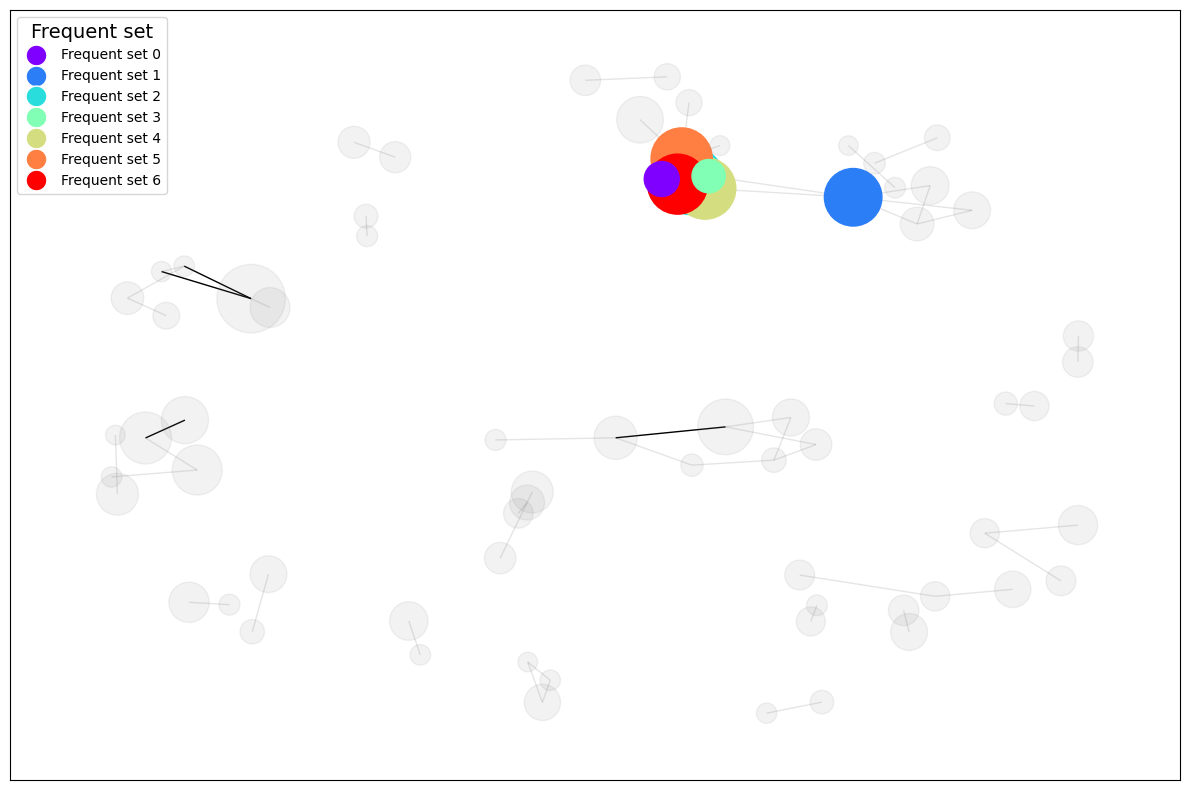

In [ ]:
import networkx as nx
from mlxtend.frequent_patterns import fpgrowth
import pandas as pd

def apriori_on_graph(graph, min_support):
    """
    Implémente l'algorithme Apriori pour trouver des ensembles fréquents de nœuds dans un graphe.
    
    :param graph: Graph NetworkX
    :param min_support: Fréquence minimale pour qu'un ensemble soit considéré comme fréquent
    :return: Liste des ensembles fréquents avec leurs supports
    """
    # Initialiser les ensembles fréquents et les supports
    frequent_sets = []
    support_counts = {}
    
    # Étape 1 : Calculer les 1-itemsets fréquents
    for node in graph.nodes:
        support_counts[frozenset([node])] = len(list(nx.neighbors(graph, node)))
    print(f"Support counts: {support_counts}")
    
    # Filtrer les itemsets fréquents par min_support
    current_level_sets = {itemset for itemset, support in support_counts.items() if support >= min_support}
    frequent_sets.extend(current_level_sets)
    
    k = 2  # Taille des itemsets
    while current_level_sets:
        # Étape 2 : Générer les candidats de taille k
        candidates = set(
            frozenset(a.union(b))
            for a in current_level_sets for b in current_level_sets
            if len(a.union(b)) == k
        )
        
        # Étape 3 : Calculer le support des candidats
        candidate_supports = {}
        for candidate in candidates:
            count = 0
            for edge in graph.edges:
                if candidate.issubset(edge):
                    count += 1
            if count >= min_support:
                candidate_supports[candidate] = count
        
        # Filtrer les candidats fréquents
        current_level_sets = {itemset for itemset, support in candidate_supports.items() if support >= min_support}
        frequent_sets.extend(current_level_sets)
        
        k += 1
    
    return frequent_sets


def fp_growth_on_graph(graph, min_support):
    """
    Implémente l'algorithme FP-Growth pour trouver des ensembles fréquents de nœuds dans un graphe.
    
    :param graph: Graph NetworkX
    :param min_support: Fréquence minimale pour qu'un ensemble soit considéré comme fréquent
    :return: Liste des ensembles fréquents avec leurs supports
    """
    
    # Créer un DataFrame de transactions
    transactions = []
    for edge in graph.edges:
        transactions.append(list(edge))

    # Appliquer l'algorithme FP-Growth
    transactions_df = pd.DataFrame(transactions)
    frequent_itemsets = fpgrowth(transactions_df, min_support=min_support, use_colnames=True)
    
    return frequent_itemsets['itemsets'].values

# Appliquer l'algorithme Apriori sur le graph
min_support = 5
frequent_sets_apriori = apriori_on_graph(G_products, min_support)
print(f"\n___ Apriori frequent sets (support >= {min_support}) ___")
print(frequent_sets_apriori)

    
# Appliquer l'algorithme FP-Growth sur le graph
min_support = 0.01
frequent_sets_fp_growth = fp_growth_on_graph(G_products, min_support)
print(f"\n___ FP-Growth frequent sets (support >= {min_support}) ___")
print(frequent_sets_fp_growth)

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def plot_association_graph(graph, frequent_sets, min_support):
    """
    Dessine un graphique de réseau avec les ensembles fréquents mis en évidence.
    
    :param graph: Graph NetworkX
    :param frequent_sets: Liste des ensembles fréquents
    :param min_support: Fréquence minimale pour qu'un ensemble soit considéré comme fréquent
    """
    
    # Créer un dictionnaire pour mapper les nœuds aux ensembles fréquents
    node_sets = {}
    for node in graph.nodes:
        for itemset in frequent_sets:
            if node in itemset:
                node_sets[node] = itemset
                break
        else:
            node_sets[node] = None
    
    # Créer un graphique de réseau
    plt.figure(figsize=(12, 8))
    position = nx.spring_layout(graph, k=0.3, iterations=50)
    node_sizes = [graph.nodes[n]['count'] * 5 for n in graph.nodes]
    node_colors = [len(node_sets[n]) if node_sets[n] else 0 for n in graph.nodes]
    nx.draw_networkx(graph, position, node_color=node_colors, node_size=node_sizes, cmap=plt.cm.plasma, alpha=0.6, with_labels=False)
    plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.plasma), label='Frequent set size')
    plt.title(f"Association graph with frequent sets (support >= {min_support})")
    plt.tight_layout()
    plt.savefig('./images/graph-products-association.png')
    plt.show()
    
    
